## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import nltk

### Reading the data

In [2]:
data=pd.read_csv('Reviews.csv')
print("dataset size is {}".format(data.shape))
data=data.head(5000)
print("Sample size id {}".format(data.shape))
data.head(10)

dataset size is (568454, 10)
Sample size id (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


### Step 1: Basic EDA

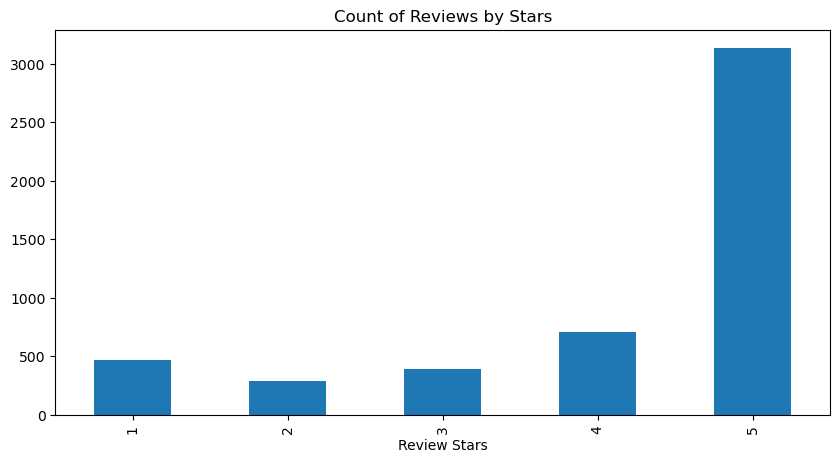

In [23]:
ax = data['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

### Step 2: Basic NLP

In [3]:
sample=data.Text[15]
print(sample)
tokens=nltk.word_tokenize(sample)
tokens[:10]

My daughter loves twizzlers and this shipment of six pounds really hit the spot. It's exactly what you would expect...six packages of strawberry twizzlers.


['My',
 'daughter',
 'loves',
 'twizzlers',
 'and',
 'this',
 'shipment',
 'of',
 'six',
 'pounds']

In [4]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('My', 'PRP$'),
 ('daughter', 'NN'),
 ('loves', 'VBZ'),
 ('twizzlers', 'NNS'),
 ('and', 'CC'),
 ('this', 'DT'),
 ('shipment', 'NN'),
 ('of', 'IN'),
 ('six', 'CD'),
 ('pounds', 'NNS')]

In [5]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  My/PRP$
  daughter/NN
  loves/VBZ
  twizzlers/NNS
  and/CC
  this/DT
  shipment/NN
  of/IN
  six/CD
  pounds/NNS
  really/RB
  hit/VBD
  the/DT
  spot/NN
  ./.
  It/PRP
  's/VBZ
  exactly/RB
  what/WP
  you/PRP
  would/MD
  expect/VB
  .../:
  six/CD
  packages/NNS
  of/IN
  strawberry/NN
  twizzlers/NNS
  ./.)


### Step 3. VADER Seniment Scoring
We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:
Stop words are removed
each word is scored and combined to a total score.

In [6]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [7]:
sia.polarity_scores(sample)

{'neg': 0.0, 'neu': 0.861, 'pos': 0.139, 'compound': 0.5719}

In [8]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [9]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(data, how='left')
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


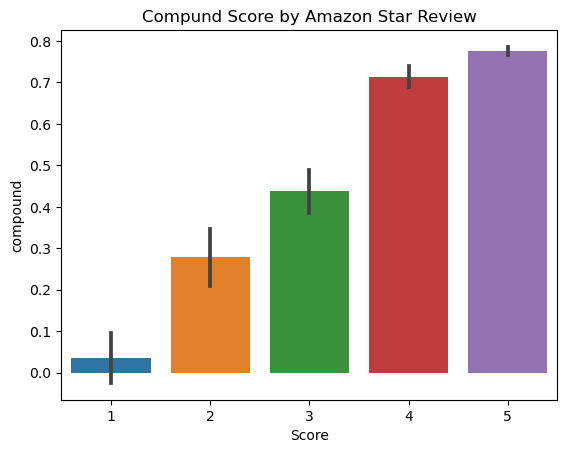

In [10]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

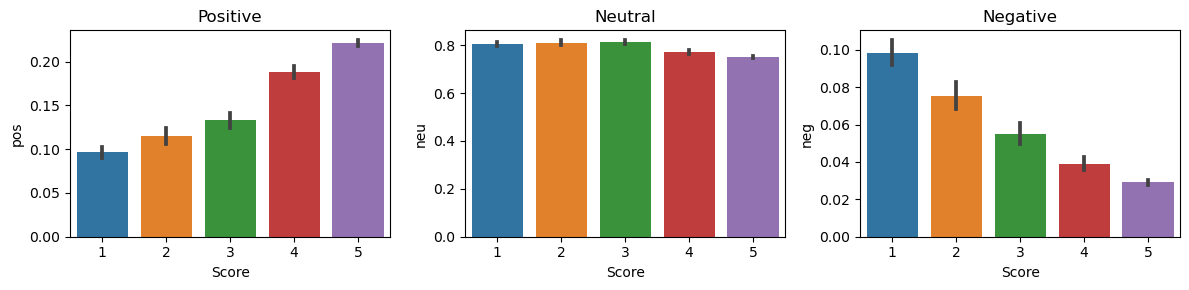

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

### Step 4. Roberta Pretrained Model

Use a model trained of a large corpus of data.

Transformer model accounts for the words but also the context related to other words.

In [12]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [13]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

C:\Users\kiran\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kiran\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [15]:
# VADER results on example
print(sample)
sia.polarity_scores(sample)

My daughter loves twizzlers and this shipment of six pounds really hit the spot. It's exactly what you would expect...six packages of strawberry twizzlers.


{'neg': 0.0, 'neu': 0.861, 'pos': 0.139, 'compound': 0.5719}

In [14]:
encoded_text = tokenizer(sample, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0045621186, 'roberta_neu': 0.03232536, 'roberta_pos': 0.96311253}


In [16]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [19]:
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/5000 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863
Broke for id 1053
Broke for id 1070
Broke for id 1156
Broke for id 1321
Broke for id 1375
Broke for id 1498
Broke for id 1575
Broke for id 1796
Broke for id 1826
Broke for id 2169
Broke for id 2248
Broke for id 2476
Broke for id 2492
Broke for id 2584
Broke for id 2610
Broke for id 2897
Broke for id 2898
Broke for id 2902
Broke for id 2928
Broke for id 2942
Broke for id 2944
Broke for id 2947
Broke for id 2948
Broke for id 3022
Broke for id 3023
Broke for id 3025
Broke for id 3306
Broke for id 3788
Broke for id 3969
Broke for id 4107
Broke for id 4110
Broke for id 4307
Broke for id 4316
Broke for id 4408
Broke for id 4483
Broke for id 4512
Broke for id 4553
Broke for id 4583


### Step 5. Combine and compare

In [20]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(data, how='left')

In [21]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

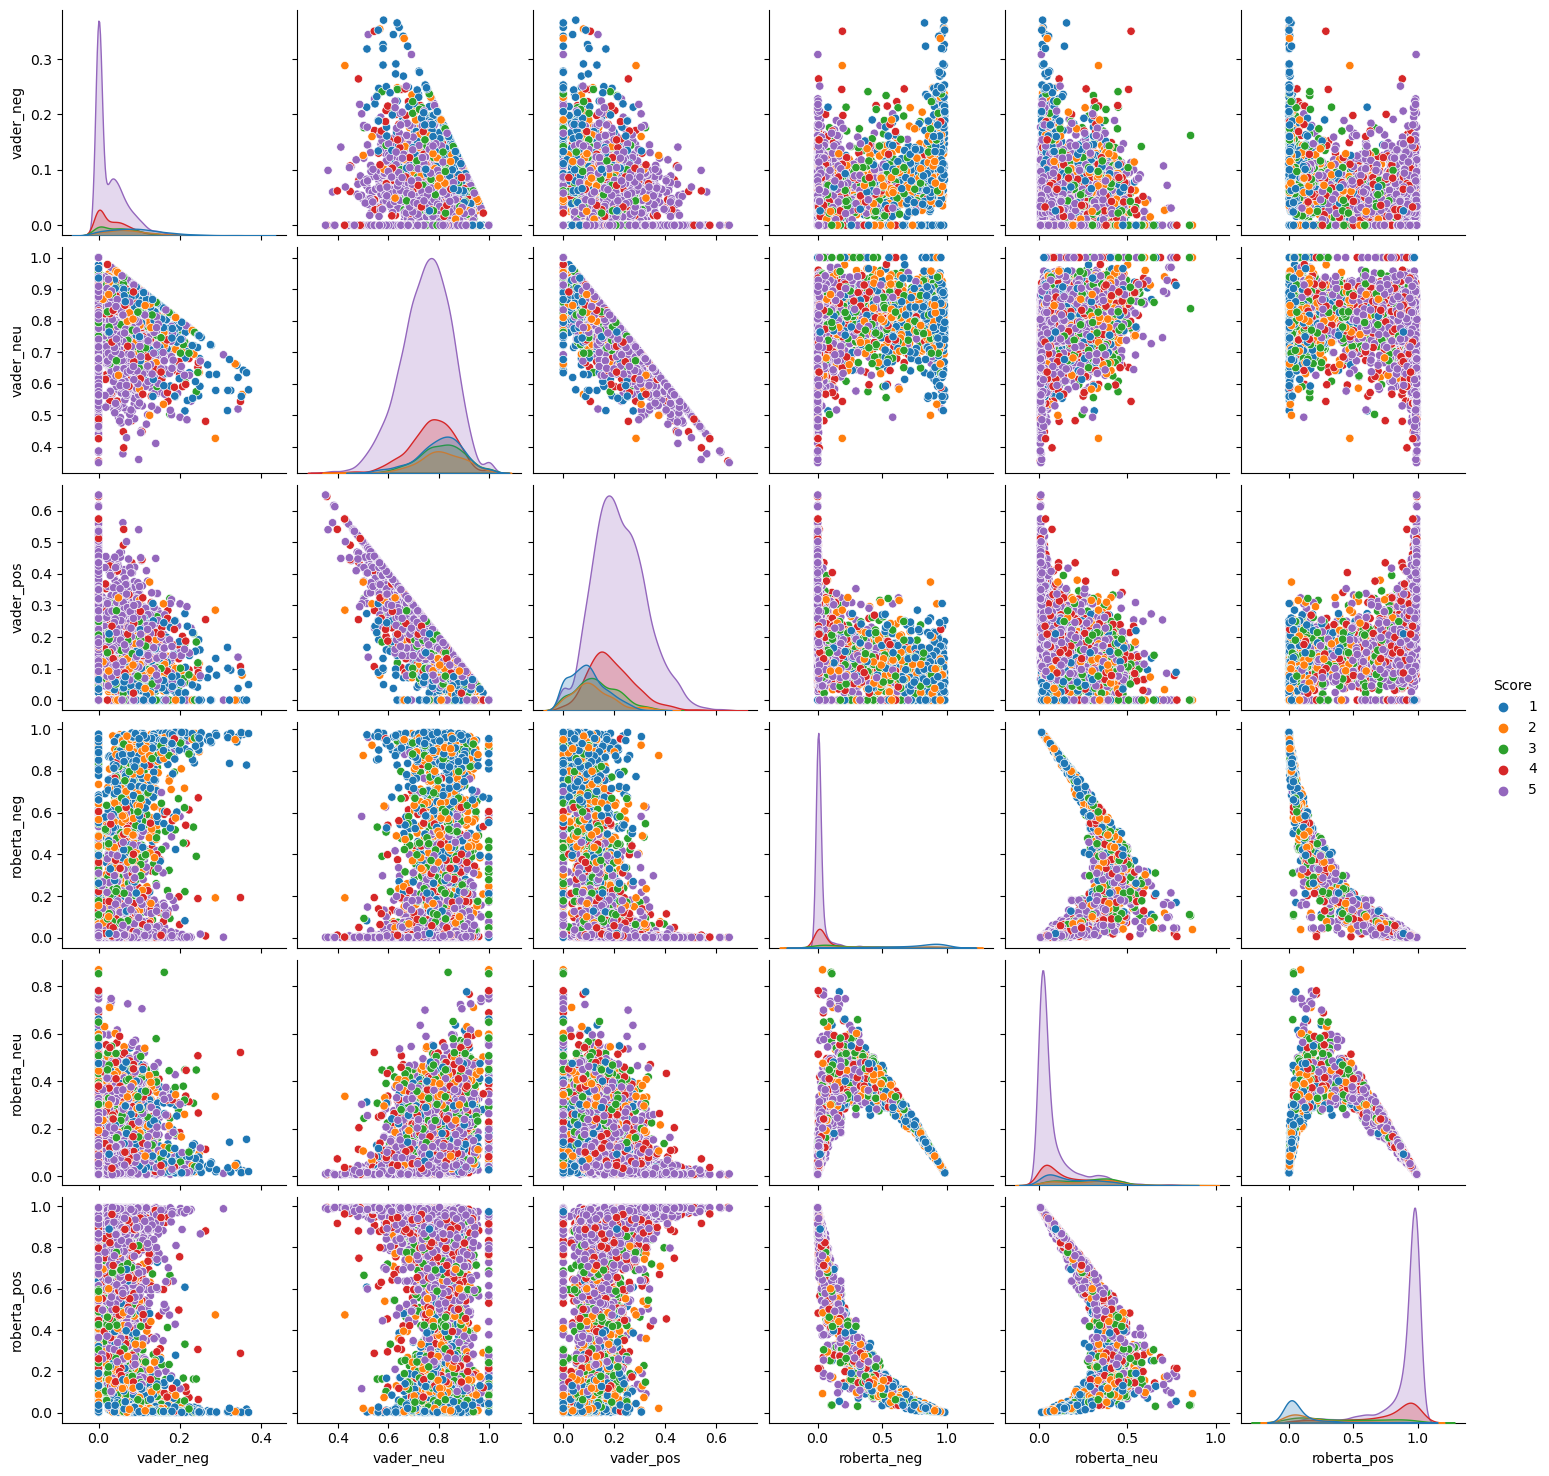

In [22]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

### Lets find few extreme results where:
i) The rating is low and roberta model determined as positive

In [25]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'Bisquick GF is easy to use. Pancakes and muffins are very<br />tasty. The product is quick and easy to use. It makes my day.  Gram'

ii) The rating is High and roberta model determined as negative

In [26]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

### Extra: The Transformers Pipeline

Quick & easy way to run sentiment predictions

In [24]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

C:\Users\kiran\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kiran\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [29]:
sent_pipeline('This projects works amazingly')

[{'label': 'POSITIVE', 'score': 0.9998520612716675}]

In [28]:
sent_pipeline('I am Handsome but no one pays attention towards me')

[{'label': 'NEGATIVE', 'score': 0.9115079641342163}]

## The End